In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.style.use('ggplot')

In [2]:
WORKING_DIR = '/scratch/msc24h18/msc_project'
FILE_PATH = 'data/LBE247_analyzed/LBE247_ID294YR/pulsedAmplitudeSweep_DCIV_20240919110332/pulsedAmplitudeSweep_DCIV[LBE247_ID294YR(1)]20240919110516/pulsedAmplitudeSweep_DCIV[LBE247_ID294YR(1)]20240919110516_Summary.dat'

data = pd.read_csv(os.path.join(WORKING_DIR, FILE_PATH), skiprows=6)

data.head()

,Pulse Number,index,Pulse Amplitude (V),R_low (ohm),R_high (ohm)
0,1,4,0.4,8.435757e+07,9.481998e+07
1,2,5,0.5,8.538324e+07,9.619269e+07
2,3,6,0.6,8.704281e+07,9.824437e+07
3,4,7,0.7,8.942464e+07,1.012843e+08
4,5,8,0.8,9.324096e+07,1.058302e+08


Number of LTP pulses: 22
Number of LTD pulses: 27


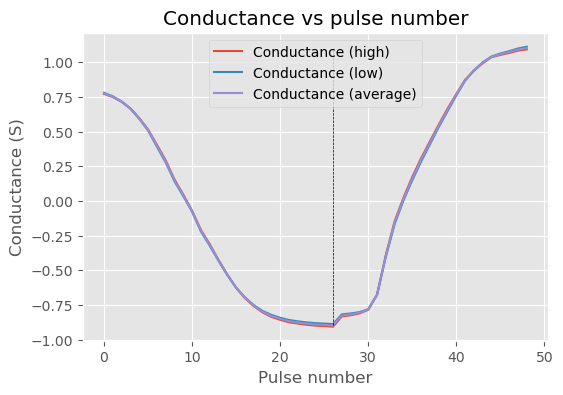

In [3]:
conductance_l = np.array(1 / data['R_high (ohm)'])
conductance_h = np.array(1 / data['R_low (ohm)'])
conductance = (conductance_l + conductance_h) / 2


def normalize(c):
    return 2 * (c - c.mean()) / (c.max() - c.min())


conductance_l = normalize(conductance_l)
conductance_h = normalize(conductance_h)
conductance = normalize(conductance)

# ltp pulses are expected to be positive for fitting to work
pulses = np.array([-1 if v > 0 else 1 for v in data['Pulse Amplitude (V)']])
conductance_ltp = conductance[np.where(pulses == 1)[0]]
conductance_ltd = conductance[np.where(pulses == -1)[0]]
pulse_change_idx = np.where(np.diff(pulses) != 0)[0]

print(f"Number of LTP pulses: {len(conductance_ltp)}")
print(f"Number of LTD pulses: {len(conductance_ltd)}")

fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(conductance_h, label='Conductance (high)')
ax.plot(conductance_l, label='Conductance (low)')
ax.plot(conductance, label='Conductance (average)')
ax.vlines(pulse_change_idx, conductance.min(), conductance.max(), color='k', ls='--', lw=0.5)
ax.set(xlabel="Pulse number", ylabel="Conductance (S)", title="Conductance vs pulse number")
ax.legend()
plt.show()

In [4]:
from aihwkit.utils.fitting import fit_measurements


def fit_model(device_config):
    params = {'dw_min': (0.1, 0.001, 1.0),
              'up_down': (0.0, -0.99, 0.99),
              'w_max': (1.0, 0.1, 2.0),
              'w_min': (-1.0, -2.0, -0.1),
              }

    result, device_config_fit, best_model_fit = fit_measurements(
        params,
        pulses,
        conductance,
        device_config)

    print(device_config_fit)

    fig, ax = plt.subplots(figsize=(6, 4))
    ax.plot(conductance, label='Measured')
    ax.plot(best_model_fit, label='Fit')
    ax.vlines(pulse_change_idx, conductance.min(), conductance.max(), color='k', ls='--', lw=0.5)
    ax.set(xlabel="Pulse number", ylabel="Conductance (S)", title=str(device_config))
    ax.legend()
    plt.show()

    # return result, device_config_fit, best_model_fit

ConstantStepDevice(
    dw_min=0.12870200655758657,
    dw_min_dtod=0.0,
    dw_min_std=0.0,
    reset_std=0.0,
    up_down=0.32135377110159946,
    up_down_dtod=0.0,
    w_max=1.0594228459805168,
    w_max_dtod=0.0,
    w_min=-0.9308169729796667,
    w_min_dtod=0.0
)


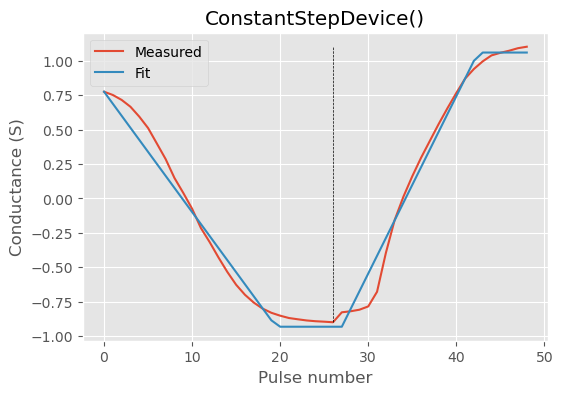

ExpStepDevice(
    dw_min=0.13239790445040217,
    dw_min_dtod=0.0,
    dw_min_std=0.0,
    reset_std=0.0,
    up_down=0.32996740405081604,
    up_down_dtod=0.0,
    w_max=1.0716254635295037,
    w_max_dtod=0.0,
    w_min=-0.9435108946550814,
    w_min_dtod=0.0
)


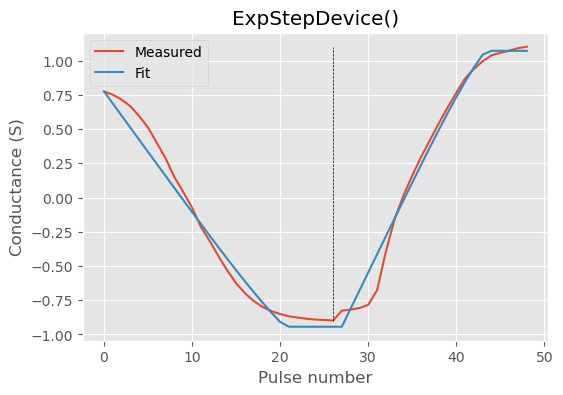

LinearStepDevice(
    dw_min=0.12870200655758657,
    dw_min_dtod=0.0,
    dw_min_std=0.0,
    reset_std=0.0,
    up_down=0.32135377110159946,
    up_down_dtod=0.0,
    w_max=1.0594228459805168,
    w_max_dtod=0.0,
    w_min=-0.9308169729796667,
    w_min_dtod=0.0,
    gamma_up_dtod=0.0,
    gamma_down_dtod=0.0
)


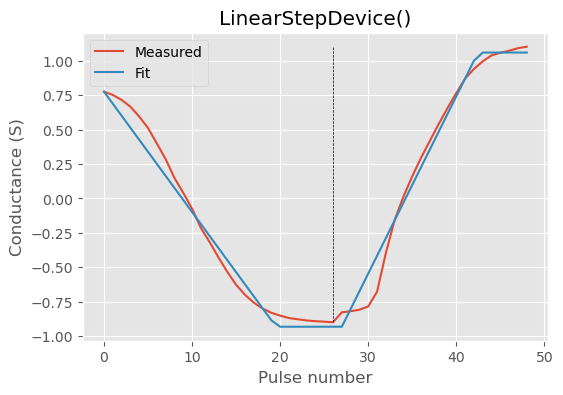

PowStepDevice(
    dw_min=0.24992464919673674,
    dw_min_dtod=0.0,
    dw_min_std=0.0,
    reset_std=0.0,
    up_down=0.3617504779971701,
    up_down_dtod=0.0,
    w_max=1.9999987999185522,
    w_max_dtod=0.0,
    w_min=-1.999995583079859,
    w_min_dtod=0.0,
    pow_gamma_dtod=0.0
)


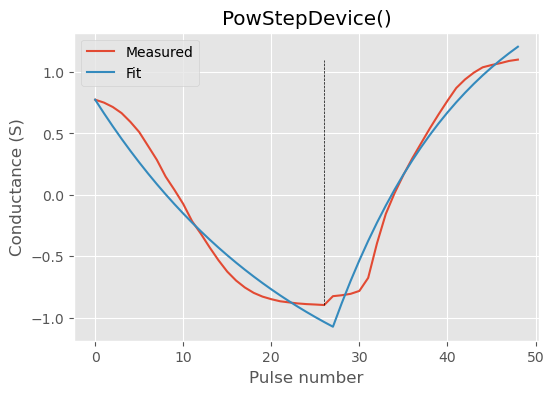

SoftBoundsDevice(
    dw_min=0.12498640781095355,
    dw_min_dtod=0.0,
    dw_min_std=0.0,
    reset_std=0.0,
    up_down=0.3618106759251749,
    up_down_dtod=0.0,
    w_max=1.9999999992126998,
    w_max_dtod=0.0,
    w_min=-1.9999999910436455,
    w_min_dtod=0.0
)


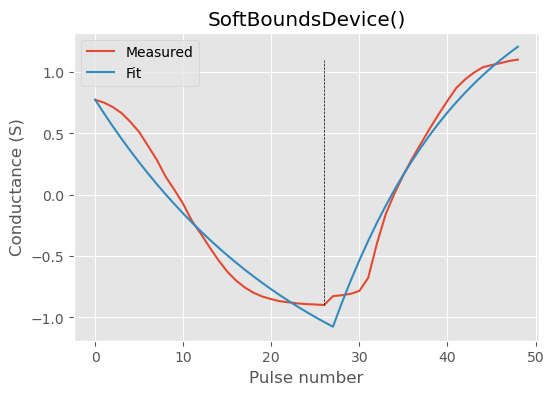

In [5]:
from aihwkit.simulator.configs import (
    ConstantStepDevice,
    ExpStepDevice,
    LinearStepDevice,
    PowStepDevice,
    SoftBoundsDevice
)

fit_model(ConstantStepDevice())
fit_model(ExpStepDevice())
fit_model(LinearStepDevice())
fit_model(PowStepDevice())
fit_model(SoftBoundsDevice())

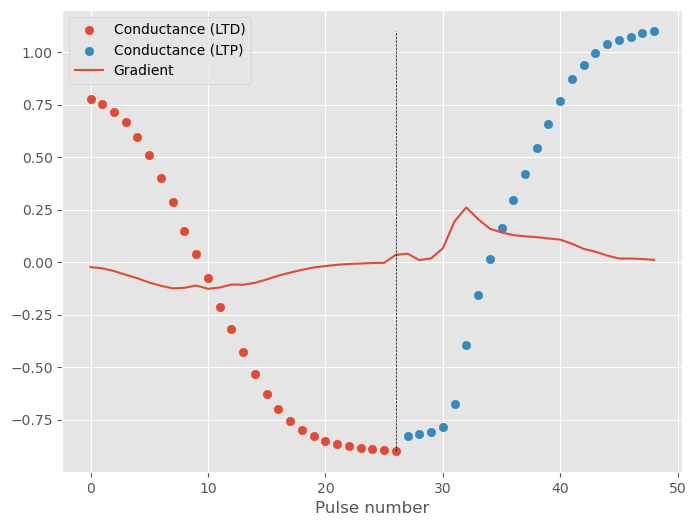

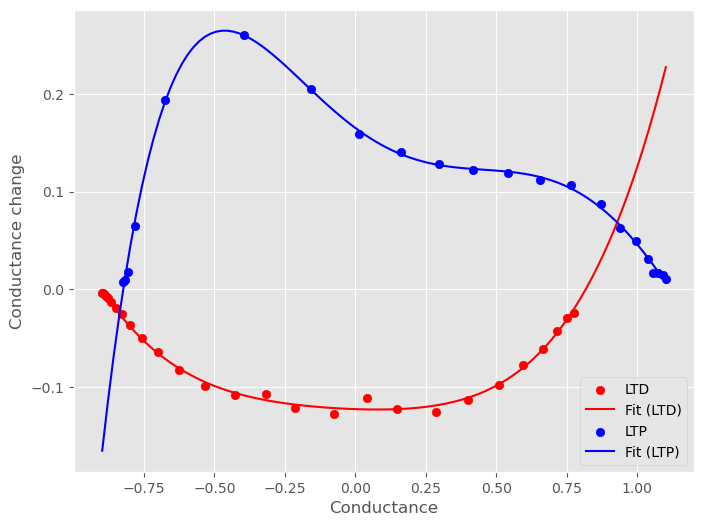

In [6]:
from numpy.polynomial.polynomial import Polynomial
pulses_ltp = np.where(pulses == 1)[0]
pulses_ltd = np.where(pulses == -1)[0]

fig, ax = plt.subplots(figsize=(8, 6))
ax.scatter(pulses_ltd, conductance_ltd, label='Conductance (LTD)')
ax.scatter(pulses_ltp, conductance_ltp, label='Conductance (LTP)')
# ax.plot(conductance)
ax.plot(np.gradient(conductance), label='Gradient')
ax.vlines(pulse_change_idx, conductance.min(), conductance.max(), color='k', ls='--', lw=0.5)
ax.set(xlabel="Pulse number")
ax.legend()
plt.show()

grad_ltd = np.gradient(conductance_ltd)
grad_ltp = np.gradient(conductance_ltp)

fit_degree = 5
fit_grad_ltd = Polynomial.fit(conductance_ltd, grad_ltd, fit_degree)
fit_grad_ltp = Polynomial.fit(conductance_ltp, grad_ltp, fit_degree)

xvals = np.linspace(conductance.min(), conductance.max(), 100)

fig, ax = plt.subplots(figsize=(8, 6))
ax.scatter(conductance_ltd, grad_ltd, label='LTD', color='r')
ax.plot(xvals, fit_grad_ltd(xvals), label='Fit (LTD)', color='r')

ax.scatter(conductance_ltp, grad_ltp, label='LTP', color='b')
ax.plot(xvals, fit_grad_ltp(xvals), label='Fit (LTP)', color='b')

ax.set(xlabel="Conductance", ylabel="Conductance change")
ax.legend()
plt.show()

PiecewiseStepDevice(
    dw_min=0.8206472185089037,
    dw_min_dtod=0.0,
    dw_min_std=0.0,
    reset_std=0.0,
    up_down=-0.030147609463787584,
    up_down_dtod=0.0,
    w_max=1.1522620505409014,
    w_max_dtod=0.0,
    w_min=-1.1035877799602885,
    w_min_dtod=0.0,
    piecewise_up=[
        0.49014673626969973,
        0.2693977269153332,
        0.09822420377381302,
        0.030997982260010937,
        0.12514810830307282,
        0.19039537681191002,
        0.23223371291048187,
        0.2555165617179926,
        0.2644916856767113,
        0.2628359618797925,
        0.25369017939909744,
        0.2396938366130142,
        0.22301993853427857,
        0.2054097941377952,
        0.18820781368845774,
        0.17239630606897005,
        0.1586302761076667,
        0.14727222190633363,
        0.1384269321680291,
        0.1319762835249042,
        0.12761403786602382,
        0.12488063966518714,
        0.12319801330874852,
        0.12190436042343816,
        0.1202889572041

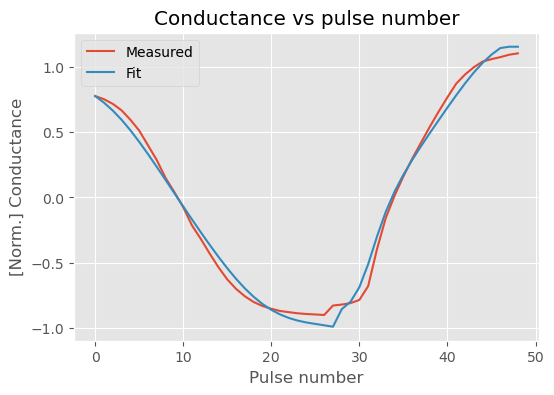

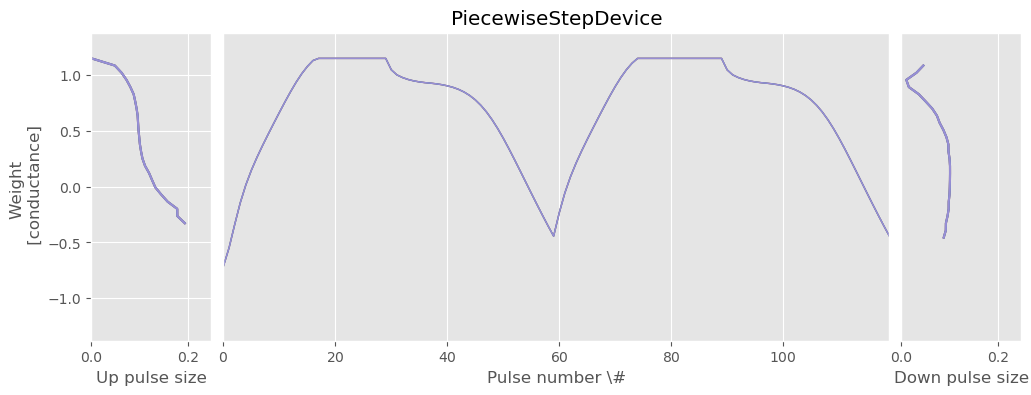

In [15]:
from aihwkit.utils.visualization import get_tile_for_plotting, compute_pulse_response
from aihwkit.simulator.configs import build_config
from aihwkit.utils.fitting import fit_measurements
from aihwkit.simulator.configs import PiecewiseStepDevice
from aihwkit.utils.visualization import plot_device_compact

condvals = np.linspace(-1, 1, 32)
fit_ltp_vals = list(np.abs(fit_grad_ltp(condvals)))
fit_ltd_vals = list(np.abs(fit_grad_ltd(condvals)))

params = {'dw_min': (0.1, 0.001, 1.0),
          'up_down': (0.0, -0.99, 0.99),
          'w_max': (1.0, 0.1, 2.0),
          'w_min': (-1.0, -2.0, -0.1),
          }

result, pw_device_fit, pw_device_response = fit_measurements(
    params,
    pulses,
    conductance,
    PiecewiseStepDevice(
        piecewise_up=fit_ltp_vals,
        piecewise_down=fit_ltd_vals
    ))

print(pw_device_fit)

fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(conductance, label='Measured')
ax.plot(pw_device_response, label='Fit')
ax.set(xlabel="Pulse number", ylabel="[Norm.] Conductance", title="Conductance vs pulse number")
ax.legend()
plt.show()

rpu_config = build_config('sgd', pw_device_fit)
plot_device_compact(pw_device_fit, n_steps=30, n_traces=3);